In [1]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [1]:
# If using mac run:
import os

# Set the environment variable to enable CPU fallback for MPS
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [2]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms

from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
    
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
    
else:
    print ("MPS device not found.")

tensor([1.], device='cuda:0')


In [5]:
class VGG16(nn.Module):
	def __init__(self):
		super().__init__()
		
		# First convolution block. 2 3x3 convs followed by a 2x2 
		self.conv1 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=3,
			out_channels=64,
		)
		self.relu1 = nn.ReLU()
		self.conv2 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=64,
			out_channels=64,
		)
		self.relu2 = nn.ReLU()	
		self.maxpool1 = nn.MaxPool2d(
			kernel_size=(2,2),
			stride=2,
		)
		
		# Second convolution block same as above, difference is in number of channels outputted (128 here)
		self.conv3 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=64,
			out_channels=128,
		)
		self.relu3 = nn.ReLU()
		self.conv4 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=128,
			out_channels=128,
		)
		self.relu4 = nn.ReLU()
		self.maxpool2 = nn.MaxPool2d(
			kernel_size=(2, 2),
			stride=2,
		)
		
		# Third convolution block, this one has 3 convolutions before MP layer and more channels outputted (256)
		self.conv5 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=128,
			out_channels=256,
		)
		self.relu5 = nn.ReLU()
		self.conv6 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=256,
			out_channels=256,
		)
		self.relu6 = nn.ReLU()
		self.conv7 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=256,
			out_channels=256,
		)
		self.relu7 = nn.ReLU()
		self.maxpool3 = nn.MaxPool2d(
			kernel_size=(2, 2),
			stride=2,
		)
		
		# Fourth convolution block, same as third (3 convolutional layers) but more channels outputted (512)
		self.conv8 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=256,
			out_channels=512,
		)
		self.relu8 = nn.ReLU()
		self.conv9 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=512,
			out_channels=512,
		)
		self.relu9 = nn.ReLU()
		self.conv10 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=512,
			out_channels=512,
		)
		self.relu10 = nn.ReLU()
		self.maxpool4 = nn.MaxPool2d(
			kernel_size=(2, 2),
			stride=2,
		)
		
		# Fifth and final convolutional block, exactly the same as the fourth
		self.conv11 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=512,
			out_channels=512,
		)
		self.relu11 = nn.ReLU()
		self.conv12 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=512,
			out_channels=512,
		)
		self.relu12 = nn.ReLU()
		self.conv13 = nn.Conv2d(
			kernel_size=(3, 3),
			stride=1,
			padding=1,
			in_channels=512,
			out_channels=512,
		)
		self.relu13 = nn.ReLU()
		self.maxpool5 = nn.MaxPool2d(
			kernel_size=(2, 2),
			stride=2,
		)
		
		# Fully connected layers, first two have dropout of p=0.5
		self.fc1 = nn.Linear(
			in_features=25088,
			out_features=4096,
		)
		self.relu14 = nn.ReLU()
		self.dropout1 = nn.Dropout(p=0.5)
		
		# Second fully connected layer
		self.fc2 = nn.Linear(in_features=4096,
		                     out_features=4096,
		)
		self.relu15 = nn.ReLU()
		self.dropout2 = nn.Dropout(p=0.5)
		
		# Final output linear layer (will create 2, one for ImageNet and one for Cifar10)
		#self.fc3 = nn.Linear(
		#	in_features=4096,
		#	out_features=1000,
		#)
		self.fc3 = nn.Linear(
			in_features=4096,
			out_features=10,
		)
	
	def forward(self, x):
		# First conv block
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool1(x)
		#print(f'Shape after 1st block: {x.shape}')
		
		# Second conv block
		x = self.conv3(x)
		x = self.relu3(x)
		x = self.conv4(x)
		x = self.relu4(x)
		x = self.maxpool2(x)
		#print(f'Shape after 2nd block: {x.shape}')
		
		# Third conv block
		x = self.conv5(x)
		x = self.relu5(x)
		x = self.conv6(x)
		x = self.relu6(x)
		x = self.conv7(x)
		x = self.relu7(x)
		x = self.maxpool3(x)
		#print(f'Shape after 3rd block: {x.shape}')
		      
		# Fourth conv block
		x = self.conv8(x)
		x = self.relu8(x)
		x = self.conv9(x)
		x = self.relu9(x)
		x = self.conv10(x)
		x = self.relu10(x)
		x = self.maxpool4(x)
		#print(f'Shape after 3rd block: {x.shape}')
		
		# Fifth conv block
		x = self.conv11(x)
		x = self.relu11(x)
		x = self.conv12(x)
		x = self.relu12(x)
		x = self.conv13(x)
		x = self.relu13(x)
		x = self.maxpool5(x)
		#print(f'Shape after 3rd block: {x.shape}')
		
		# Must flatten output of convolutions for input the linear layers
		x = torch.flatten(x, start_dim=1)
		#print(f'Shape after flattening: {x.shape}')
		
		x = self.fc1(x)
		x = self.relu14(x)
		x = self.dropout1(x)
		#print(f'Shape after 1st FC: {x.shape}')
		
		x = self.fc2(x)
		x = self.relu15(x)
		x = self.dropout2(x)
		#print(f'Shape after 2nd FC: {x.shape}')
		
		x = self.fc3(x)
		#print(f'Shape after 3rd FC: {x.shape}')
		
		return x
	
# Init model weights by VGG scheme
def vgg_weight_init(net):
    """
    Initializes weights as per the VGG scheme.
    """
    if isinstance(net, nn.Conv2d):
        nn.init.normal_(net.weight, mean=0.0, std=0.01)
        if net.bias is not None:
            nn.init.constant_(net.bias, 0)
    elif isinstance(net, nn.Linear):
        nn.init.normal_(net.weight, mean=0.0, std=0.01)
        nn.init.constant_(net.bias, 0)
    # You can add initialization for other types of layers if needed

def glorot_uniform_init(net):
    if isinstance(net, nn.Linear) or isinstance(net, nn.Conv2d):
        nn.init.xavier_uniform_(net.weight)
        if net.bias is not None:
            nn.init.constant_(net.bias, 0)

model = VGG16()
model.apply(glorot_uniform_init)
model.to(device)

VGG16(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu6): ReLU()
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu7): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv8): Conv2d(256, 512, kernel_siz

In [6]:
# Create a dummy input tensor with the expected input size
# Assuming the input size is (batch_num, channels, height, width)
dummy_input = torch.randn(1, 3, 224, 224)  # For example, a single 224x224 RGB image
dummy_input = dummy_input.to(device)

# Pass the dummy input through the network
output = model(dummy_input)

In [6]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.48227 ,0.4465], std=[0.2470, 0.2435, 0.2616]), #Normalize using mean and std dev of cifar10
])

# Load datasets
train_dataset = CIFAR10(root='./CIFAR', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./CIFAR', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # 256 batch size for imagenet
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


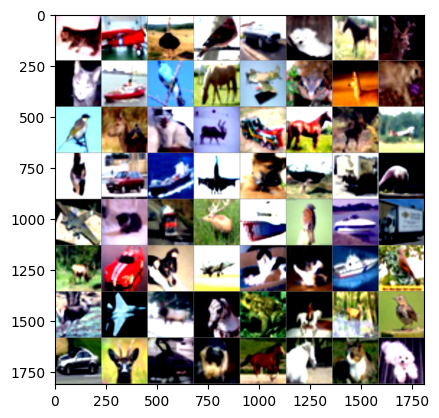

In [7]:
# Let's show some of the training images, for fun.
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
	img = img / 2 + 0.5  # unnormalize
	npimg = img.numpy()
	plt.imshow(np.transpose(npimg, (1, 2, 0)))
	plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9)

# Define learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/home/yusuf/anaconda3/envs/gpu_use/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [9]:
for epoch in range(25):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}] training loss: {train_loss:.3f}')
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in test_loader:  # Assuming test_loader is used as a validation loader
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_running_loss / len(test_loader)
    val_accuracy = 100 * val_correct / val_total
    print(f'Epoch [{epoch + 1}] validation loss: {val_loss:.3f}, accuracy: {val_accuracy:.2f}%')
    
    # Update the LR scheduler with validation loss
    scheduler.step(val_loss)


Epoch [1] training loss: 1.854
Epoch [1] validation loss: 1.437, accuracy: 46.33%
Epoch [2] training loss: 1.295
Epoch [2] validation loss: 1.082, accuracy: 61.74%
Epoch [3] training loss: 0.946
Epoch [3] validation loss: 0.816, accuracy: 71.19%
Epoch [4] training loss: 0.732
Epoch [4] validation loss: 0.759, accuracy: 73.46%
Epoch [5] training loss: 0.587
Epoch [5] validation loss: 0.671, accuracy: 77.71%
Epoch [6] training loss: 0.467
Epoch [6] validation loss: 0.720, accuracy: 77.01%
Epoch [7] training loss: 0.359
Epoch [7] validation loss: 0.685, accuracy: 78.88%
Epoch [8] training loss: 0.273
Epoch [8] validation loss: 0.634, accuracy: 80.68%
Epoch [9] training loss: 0.216
Epoch [9] validation loss: 0.644, accuracy: 80.84%
Epoch [10] training loss: 0.177
Epoch [10] validation loss: 0.727, accuracy: 80.57%
Epoch [11] training loss: 0.145
Epoch [11] validation loss: 0.728, accuracy: 80.81%
Epoch [12] training loss: 0.123
Epoch [12] validation loss: 0.738, accuracy: 80.25%
Epoch [13]

In [10]:
val_accuracy

82.96